In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import scipy.stats as stats


In [5]:
# !pip install pydataset
from pydataset import data

initiated datasets repo at: /Users/seanreed1/.pydataset/


In [10]:
cars = data('mtcars')
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mpg     32 non-null     float64
 1   cyl     32 non-null     int64  
 2   disp    32 non-null     float64
 3   hp      32 non-null     int64  
 4   drat    32 non-null     float64
 5   wt      32 non-null     float64
 6   qsec    32 non-null     float64
 7   vs      32 non-null     int64  
 8   am      32 non-null     int64  
 9   gear    32 non-null     int64  
 10  carb    32 non-null     int64  
dtypes: float64(5), int64(6)
memory usage: 3.0+ KB


In [11]:
cars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [12]:
cars.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [13]:
formula1 = 'mpg ~ cyl + wt'
model = smf.ols(formula=formula1, data=cars)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     70.91
Date:                Sun, 08 Aug 2021   Prob (F-statistic):           6.81e-12
Time:                        21:59:26   Log-Likelihood:                -74.005
No. Observations:                  32   AIC:                             154.0
Df Residuals:                      29   BIC:                             158.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.6863      1.715     23.141      0.0

In [14]:
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

In [26]:
fitted.min(), fitted.max()

(10.316068852326755, 28.827140760931357)

In [22]:
print(type(residuals), type(fitted), type(smoothed), type(top3))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


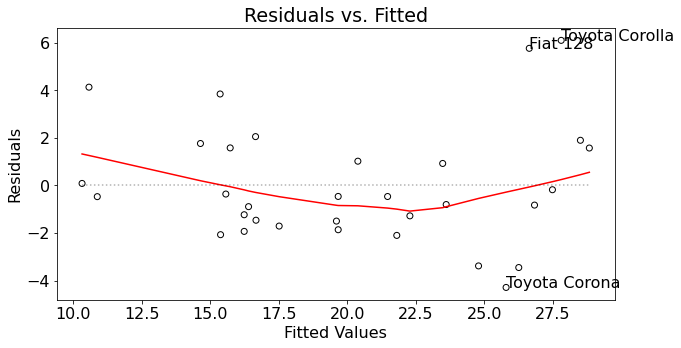

In [24]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

### Roll your own QQ Plot to get annotations

We can extract the theoretical quantiles from the stats.probplot() function. I used the internally studentized residuals here since they’ll be needed for the third and fourth graph, but you can use the raw residuals if you prefer.

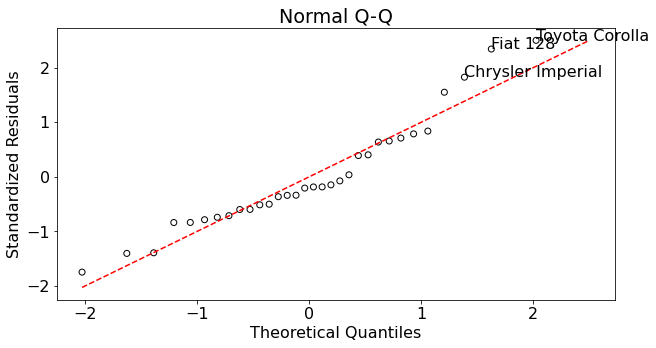

In [27]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

### Now we can test the assumption of homoskedasticity using the scale-location plot. 

Base R plots the square root of the “standardized residuals” against the fitted values. “Standardized residuals” is a bit vague so after searching online, it turns out “standardized residuals” are actually the internally studentized residuals. As I showed above, extracting the internally studentized residuals from the fitted model is straightforward. After that we’ll take the square root of their absolute value, then plot the transformed residuals against the fitted values. If the scatter in the plots is consistent across the entire range of fitted values, then we can safely assume that the data fit the assumption of homoskedasticity. I’ve annotated for the three largest values of the square root transformed studentized residuals.

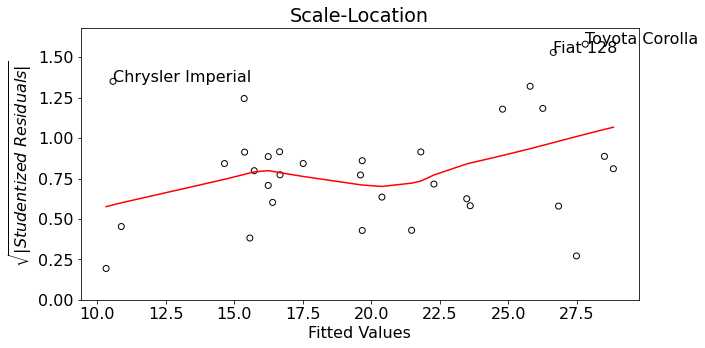

In [28]:
student_residuals = results.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = results.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)
top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
for i in top3.index:
    ax.annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
plt.show()

### Finally, I constructed the residuals vs. leverage plot. 

The response variable is again the internally studentized residuals. 

The x-axis here is the leverage, as determined via the diagonal of the OLS hat matrix. 

The tricky part here is adding in the lines for the Cook’s Distance (see here (https://emredjan.xyz/blog/2017/07/11/emulating-r-plots-in-python/) on how to construct these plots in seaborn). 

The annotations are the top three studentized residuals with the largest absolute value.

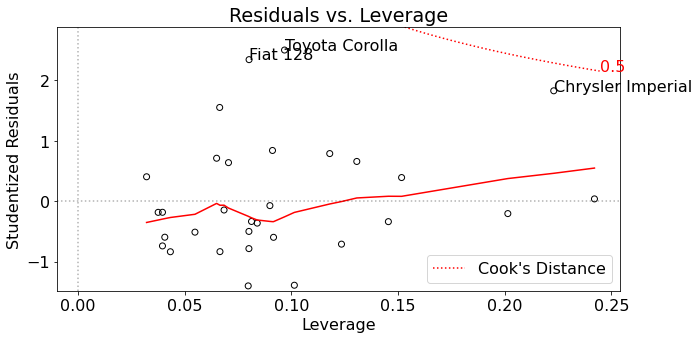

In [30]:
student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
student_residuals.index = results.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = results.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'],df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

fig, ax = plt.subplots()
x = df['leverage']
y = df['student_residuals']
xpos = max(x)+max(x)*0.01  
ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')

ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')
ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax.set_xlim(-0.01,max(x)+max(x)*0.05)


for val in top3.index:
    ax.annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(results.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')

ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax.legend()
plt.tight_layout()

source

- https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a
- https://emredjan.xyz/blog/2017/07/11/emulating-r-plots-in-python/
- https://data.library.virginia.edu/diagnostic-plots/
